Recall the purpose of Gap Analysis: determine whether two samples of data are different.  In our running example, we want to determine whether Sample 1 (salaries of female employees in the bank) is different from Sample 2 (salaries of male employees at the bank).  We generally come at Gap Analysis in two steps:
1. Plot the data in such a way that we can visually assess whether a gap exists.  These visualizations also come in handy later when communicating the results of any formal analysis.
2. Conduct a formal gap analysis using statistical techniques.

## Preliminaries
I include the data import and library import commands at the start of each lesson so that the lessons are self-contained.

In [14]:
import pandas as pd
bank = pd.read_csv('Data/Bank.csv')

## Visual gap analysis
The boxplot in Seaborn permits both an _x_ and _y_ axis.  For the resulting boxplot to make sense, the _x_ variable must be continuous (like salary) and the _y_ variable must be categorical (like gender). This permits a very quick comparison of the distribution of salary by gender.


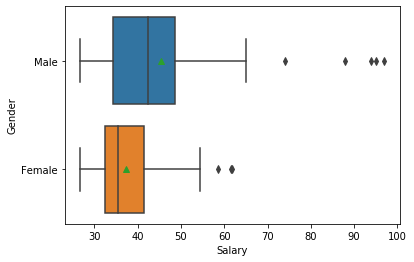

In [15]:
#ensure Seaborn is loaded
import seaborn as sns

sns.boxplot(x=bank['Salary'], y=bank['Gender'], showmeans=True);

As an aside: We can do the same kind of analysis by "JobGrade".  But recall that we left JobGrade as an integer and did not convert it to a category variable (as we did for Gender and PCJob).  We can make this conversion on the fly in order to get a boxplot:

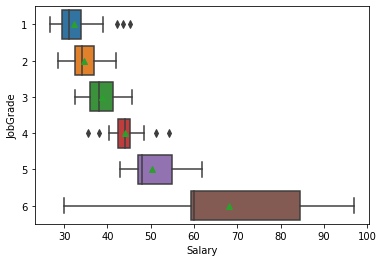

In [16]:
sns.boxplot(x=bank['Salary'], y=bank['JobGrade'].astype('category'), showmeans=True);

We see that the higher job grades (managerial roles) have both higher mean salaries and higher variability in salaries than the lower job grades.

## Histograms
As in R, comparative histograms are a bit trickier.  Given that boxplots provide much the same information, it might not be worth the effort to generate meaningful comparative histograms.  Having said that, histograms (and kernel density plots) seem to be slightly easier for some people to understand.  This is important when communicating your results.

### Faceted histograms
We used the notion of a "facet" in R to create a grid of histograms.  In this case, we want a grid with one column and two rows.  The rows correspond to different values of the "Gender" variable.  I start by creating a grid object `g` in which the rows are defined by gender.  Then, I call the map method to call the `distplot()` method for salary.  The aspect parameter simply makes the two plots a bit wider (2 x height).


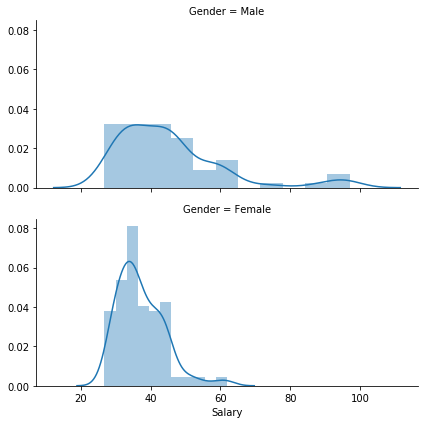

In [17]:
g = sns.FacetGrid(bank, row="Gender", aspect=2)
g.map(sns.distplot, 'Salary');

### Overlaying kernel density plots
As mentioned in our discussion of R, overlaying histograms almost never makes sense&mdash;the result is typically a mess, which is why SAS Enterprise Guide stacks them one on top of the other (as we just did above). Here is an overlayed histogram for the bank salary data:

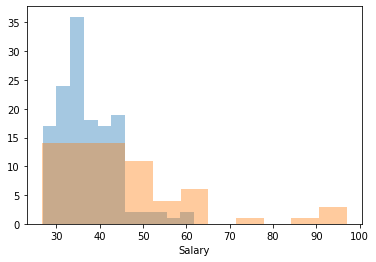

In [18]:
genders = ['Female', 'Male']
for gender in genders:
    subset = bank[bank["Gender"] == gender]
    sns.distplot(subset['Salary'], hist=True, kde=False, label=gender);

A better approach is to stack kernel density plots.

The trick here is to recognize that the plot is not drawn until the end of the code block.  Thus, if we create a loop to iterate through the different values of gender and call the resulting kernel density plot each time, the final result will be superimposed.  So here are the steps:
1. Create a list of genders over which to iterate.  I have done this manually by just typing "Female" and "Male".
2. Iterate through the list of genders
3. For each gender, create a data frame subset (as we did when filtering)
4. Call the kernel density plot for "Salary" for each subset of the data
5. Use the gender variable to populate the legend

Note that I have also added some shading to make the result look marginally cooler.

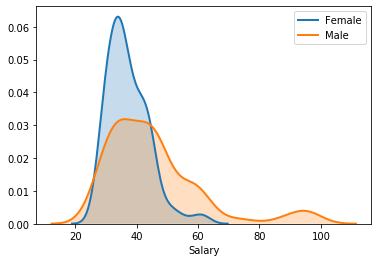

In [19]:
genders = ['Female', 'Male']
for gender in genders:
    subset = bank[bank["Gender"] == gender]
    sns.distplot(subset['Salary'], hist=False, kde=True, label=gender, kde_kws = {'shade': True, 'linewidth': 2});

Typing the genders is a bit inelegant.  Instead, we can use the data frame's `groupby()` method to generate a list of the unique genders in the data set:

In [20]:
genders = bank.groupby('Gender').groups.keys()
list(genders)

['Female', 'Male']

## _t_-Tests
We use the _t_-test at this point to formally test the hypothesis that two distributions have the same sample mean (and thus are "the same"&mdash;or at least close enough).  As in Excel and R, the two main preconditions to running the test in Python are:
1. Getting the data in the right format
2. Determining which version of the _t_-test to run: equal variance or unequal variance

### Formating the data
The easiest way to format data for _t_-tests in Python is to use the filtering and selection techniques already covered to create two arrays of data: salaries of female employees and salaries of male employees.

The steps to do this are straightforward, although the syntax may look a bit odd initially:
1. Start with the data frame `bank`
2. Create a Boolean vector (209 true or false values) based on the value of the "Gender" column (true if female, false otherwise)
3. Filter the data frame based on the Boolean vector.  This creates a subset of the original data frame.
4. Extract the "Salary" column from the subsetted data frames into two new vectors: `female_sal` and '`male_sal`

In [21]:
female_sal = bank[bank['Gender'] == "Female"]['Salary']
male_sal = bank[bank['Gender'] == "Male"]['Salary']

If we list the contents of `female_sal`, we see it contains the salaries of the 140 female employees.

In [22]:
female_sal

1      39.1
2      33.2
3      30.6
5      30.5
6      30.0
       ... 
186    50.0
187    61.8
188    43.0
190    58.5
207    30.0
Name: Salary, Length: 140, dtype: float64

## Testing for equality of variance
By default, R uses the _F_-test to determine whether the variances of the two samples are similar enough to be considered "the same". The authors of Scipy, a popular Python library for statistics, object to this choice for various technical reasons and, as a consequence, did not implement a method to perform _F_-tests.  Instead, they offer two refinements: Levene's test and Bartlett's test (Levene's and Bartlett's tests are also available in R). We will use Levene's test:   

In [23]:
# ensure the scipy stats module is loaded
from scipy import stats 

In [24]:
stats.levene(female_sal, male_sal)

LeveneResult(statistic=26.208558688866834, pvalue=7.013920590029544e-07)

The output is not particularly impressive, but it contains the one number we need: the probability (pvalue) that the two variances are equal.  Any number that ends with "e07" ($10^{-7}$) is small enough to treat as zero. We thus proceed under the assumption that the variances are unequal.

## Running the _t_-test
Although the Scipy library has a _t_-test, the statsmodels library offers a bit more functionality.  To run a _t_-test in statsmodels, we do the following: 
1. Load the library
2. Call the library's `CompareMeans.from_data()` method to convert our two vectors of salary data into a CompareMeans object, which I call `model`
3. Call the `summary()` method which provides a nice summary of the test.

Note that I have to specify the unequal variance assumption in the call to `summary()` by passing the `usevar='unequal'` argument.

In [25]:
import statsmodels.stats.api as sms

In [26]:
model = sms.CompareMeans.from_data(bank[bank['Gender'] == "Female"]['Salary'], bank[bank['Gender'] == "Male"]['Salary'])
model.summary( usevar='unequal')

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,-8.2955,2.003,-4.141,0.000,-12.283,-4.308


The summary includes:
+ the difference in sample means (-8,295.50, as we have seen before)
+ the _p_-value (appropriately rounded)
+ the 5\% confidence intervals around the difference in means.  Here we 95\% certain that the true difference between female and male salaries is somewhere between 4.3K and 12.2K

Yes, these are the same results we got in Excel, SAS, and R.